# scikit-learn DecisionTreeClassifier

## Навигация

- [Оптимизация гиперпараметров с кросс-валидацией](#Оптимизация-гиперпараметров-с-кросс-валидацией)
- [Refit на всём X_train](#Refit-на-всём-X_train)
- [Perfomance на X_test](#Perfomance-на-X_test)

In [1]:
import os
import sys
sys.path.append('..')
from typing import Dict, Tuple

import optuna
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

from my_ds_tools.classification import my_multiclass_classification_report
import src

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
DATA_PATH = os.path.join('..', 'data', 'encoded', 'encoded.csv')

N_TRIALS = 1000
N_SPLITS = 50

CAT_FEATURES = sorted(list(src.constants.CATEGORICAL_FEATURES))
CATEGORIES = [src.constants.CATEGORICAL_FEATURES[feature] for feature in CAT_FEATURES]
FEATURES_TO_IMPUT = [src.constants.QUESTION_2]
USEFUL_FOR_IMPUT = [
    src.constants.QUESTION_6, src.constants.QUESTION_8, src.constants.QUESTION_31,
    src.constants.QUESTION_32, src.constants.QUESTION_33, src.constants.QUESTION_34,
    src.constants.QUESTION_35,
]

In [4]:
data = pd.read_csv(DATA_PATH)

y = data[src.constants.TARGET]
X = data.drop(columns=src.constants.TARGET)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=src.constants.RANDOM_STATE)

## Оптимизация гиперпараметров с кросс-валидацией

[К навигации](#Навигация)

In [5]:
def objective(trial: optuna.trial.Trial) -> float:
    """Целевая функция для оптимизации гиперпараметров."""
    decision_tree_model = get_model(trial, mode='fit')
    scores = cross_val_score(
        estimator=decision_tree_model,
        X=X_train,
        y=y_train,
        scoring='accuracy',
        cv=StratifiedShuffleSplit(n_splits=N_SPLITS, random_state=src.constants.RANDOM_STATE),
        n_jobs=-1,
    )

    return scores.mean()


def get_model(trial: optuna.trial.Trial, mode: str) -> sklearn.pipeline.Pipeline:
    oe = OrdinalEncoder(
        categories=CATEGORIES, handle_unknown='use_encoded_value', unknown_value=np.nan)

    preprocessing = ColumnTransformer(
        transformers=[
            ('ordinal_encoding', oe, CAT_FEATURES),
            ('imputer', KNNImputer(), FEATURES_TO_IMPUT + USEFUL_FOR_IMPUT),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    ).set_output(transform='pandas')

    decision_tree = DecisionTreeClassifier(**get_init_hyperparams(trial, mode))

    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('decision_tree', decision_tree),
    ])

    return pipe


def get_init_hyperparams(trial: optuna.trial.Trial, mode: str) -> Dict:
    if mode == 'fit':
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        max_depth = trial.suggest_int('max_depth', 1, 10)
        min_weight_fraction_leaf = trial.suggest_float(
            'min_weight_fraction_leaf', .001, .25, step=.001)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 12)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 512)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 256)
        min_impurity_decrease = trial.suggest_float('min_impurity_decrease', .001, .25, step=.001)
    elif mode == 'refit':
        criterion = trial.params['criterion']
        max_depth = trial.params['max_depth']
        min_weight_fraction_leaf = trial.params['min_weight_fraction_leaf']
        max_leaf_nodes = trial.params['max_leaf_nodes']
        min_samples_split = trial.params['min_samples_split']
        min_samples_leaf = trial.params['min_samples_leaf']
        min_impurity_decrease = trial.params['min_impurity_decrease']
    else:
        assert False, 'ABOBA'

    init_hyperparams = dict(
        criterion=criterion,
        max_depth=max_depth,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        random_state=src.constants.RANDOM_STATE,
    )

    return init_hyperparams

In [6]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=src.constants.RANDOM_STATE),
    direction='maximize',
    study_name='decision_tree',
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
print('Лучшие гиперпараметры:')
for hyperparam, value in study.best_trial.params.items():
    print(f'* {hyperparam}: {value}')
print(f'Лучший mean Accuracy: {study.best_trial.value}')

Лучшие гиперпараметры:
* criterion: log_loss
* max_depth: 4
* min_weight_fraction_leaf: 0.17600000000000002
* max_leaf_nodes: 3
* min_samples_split: 151
* min_samples_leaf: 193
* min_impurity_decrease: 0.216
Лучший mean Accuracy: 0.5942222222222223


## Refit на всём X_train

[К навигации](#Навигация)

In [7]:
model = get_model(study.best_trial, mode='refit')
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(categories=[['многоквартирный '
                                                                              'дом',
                                                                              'таунхаус',
                                                                              'собственный '
                                                                              'дом'],
                                                                             ['общественный '
                                                                              'транспорт',
                                                                              'собственная '
                                                                              'машина/такси',
                                                                              'я '
                                                                              'обычно '
                                                                              'не '
                                                                              'пользуюсь '
                                                                              'транспортом'],
                                                                             ['замужем',
                                                                              'имею '
                                                                              'гражданского '
                                                                              'супруга',
                                                                              'одинока',
                                                                              'разведена',...
                                                   'заболевания (да/нет)',
                                                   '34. Заболевания щитовидной '
                                                   'железы (да/нет)',
                                                   '35. Наследственность '
                                                   '(да/нет)'])],
                                   verbose_feature_names_out=False)),
                ('decision_tree',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=4,
                                        max_leaf_nodes=3,
                                        min_impurity_decrease=0.216,
                                        min_samples_leaf=193,
                                        min_samples_split=151,
                                        min_weight_fraction_leaf=0.17600000000000002,
                                        random_state=42))])

## Perfomance на X_test

[К навигации](#Навигация)

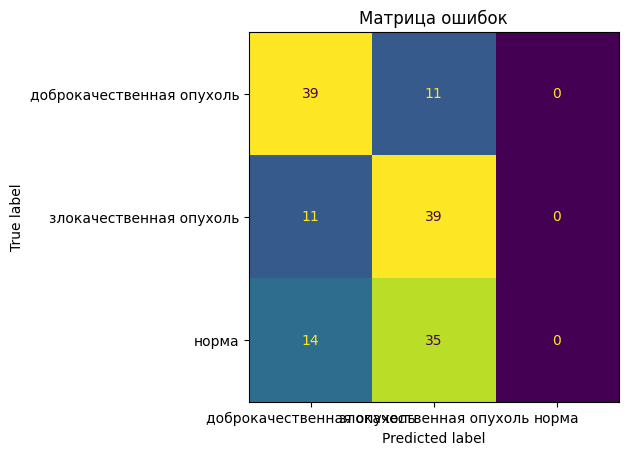

                           precision    recall  f1-score   support

доброкачественная опухоль       0.61      0.78      0.68        50
  злокачественная опухоль       0.46      0.78      0.58        50
                    норма       0.00      0.00      0.00        49

                 accuracy                           0.52       149
                macro avg       0.36      0.52      0.42       149
             weighted avg       0.36      0.52      0.42       149



E:\Projects\Breast-Cancer\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Projects\Breast-Cancer\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Projects\Breast-Cancer\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
my_multiclass_classification_report(y_test, model.predict(X_test))